# <center> Newman on custom trace and user graph </center>

In [1]:
import sys
import util
import numpy as np
import networkx as nx
import random as random
from time import time
from operator import itemgetter
import matplotlib.pyplot as plt

Load trace.

In [14]:
trace_path = "../Datasets/trace_newmanTest.txt"

Get authors.

In [15]:
Author = util.get_authors(trace_path)

Get users.

In [16]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [17]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

0 0 9 -1
1 0.19761178684143316 14 -1
2 0.22897749303630008 9 -1
3 0.27817540573473964 3 2
4 0.5629811737376177 24 -1
5 0.5680854304938732 40 -1


Useful function to flatten a list of lists or values from dict of dicts.

In [18]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]

# example
liste = [[3,5], [0,-7,12], [45]]
print("Example on {} : {}".format(liste, flatten(liste)))
dico = {1: {4:56, 2:45}, 3: {6:32}}
print("Example on {} : {}".format(dico, flatten(dico)))

Example on [[3, 5], [0, -7, 12], [45]] : [3, 5, 0, -7, 12, 45]
Example on {1: {4: 56, 2: 45}, 3: {6: 32}} : [56, 45, 32]


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [19]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N.

In [20]:
# init
E = dict()

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet of known author
    if rtid != -1 and rtid in Author:
        rtu = Author[rtid]
        if rtu != uid: # no self-edges
            if uid in E:
                if rtu in E[uid] and E[uid][rtu]<30:
                    E[uid][rtu] += 1
                else:
                    E[uid][rtu] = 1
            else:
                E[uid] = {rtu: 1}
                
# compute N
N = {u: max(flatten(E)) for u in E}

## 2. Iterations

Choose parameters.

In [21]:
eps = 0.001
repetitions = 100
max_iter = 100
verbose = False

Proceed NEW VERSION SPARSE.

In [22]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

start = time()
for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.uniform(0, 0.2)
        a = random.uniform(0.5, 1)
        b = random.uniform(0, 0.5)
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):
            
            # print state
            sys.stdout.flush()
            sys.stdout.write("repetition {}/{} --- iteration {}/{} --- elapsed time {:.3f}\r"
                             .format(k+1, repetitions, l+1, max_iter, time()-start))

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for i in E:
                ni = N[i]
                Q[i] = dict()
                for j in E[i]:
                    eij = E[i][j]
                    qij = w * a**eij * (1-a)**(ni-eij)
                    qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
                    Q[i][j] = qij
            
            # update w,a,b
            w = sum(flatten(Q)) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for i in E:
                ni = N[i]
                for j in E[i]:
                    eij = E[i][j]
                    qij = Q[i][j]
                    numerator_a += qij * eij
                    numerator_b += (1-qij) * eij
                    denominator_a += qij * ni
                    denominator_b += (1-qij) * ni
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution after at least one iteration
            # INCOMPLETE
            new_q = np.array(flatten(Q))
            if l>0 and np.linalg.norm(new_q - old_q) < eps:
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
            # register old_q
            old_q = new_q
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        print(e)
        continue

Print results.

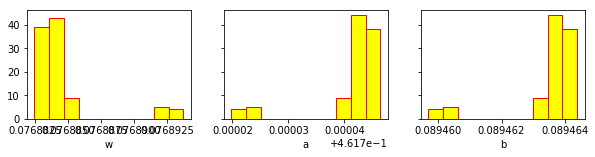

top 5 values for w and proportion
0.077 1.0

top 5 values for a and proportion
0.462 1.0

top 5 values for b and proportion
0.089 1.0

top 5 values for (w,a,b) and proportion
(0.077, 0.462, 0.089) 1.0



In [23]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)  
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("top 5 values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    valcount = list()
    for v in set(val):
        valcount.append((v, val.count(v)/len(val)))
    valcount = sorted(valcount, key=itemgetter(1), reverse=True)
    for x in valcount[:5]:
        print(x[0], x[1])
    print()
    
print("top 5 values for (w,a,b) and proportion")
val = list()
for i in range(len(results['w'])):
    val.append((round(results['w'][i],3), round(results['a'][i],3), round(results['b'][i],3)))
valcount = list()
for v in set(val):
    valcount.append((v, val.count(v)/len(val)))
valcount = sorted(valcount, key=itemgetter(1), reverse=True)
for x in valcount[:5]:
    print(x[0], x[1])
print()

Set w,a,b to the most observed values and compute Q accordingly.

w, a, b =  0.077 0.462 0.089


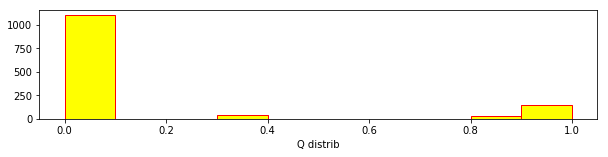

In [24]:
w, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]

# compute Q
Q = dict()
for i in E:
    ni = N[i]
    Q[i] = dict()
    for j in E[i]:
        eij = E[i][j]
        qij = w * a**eij * (1-a)**(ni-eij)
        qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
        Q[i][j] = qij
        
# plot
print("w, a, b = ", w,a,b)
plt.hist(flatten(Q), facecolor='yellow', edgecolor='red')
plt.xlabel("Q distrib")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

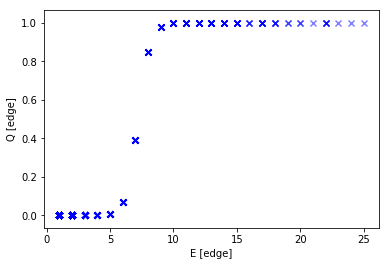

In [25]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = flatten(E)
y2plot = flatten(Q)
plt.scatter(x2plot, y2plot, color='blue', marker='x', alpha=.5)
plt.xlabel("E [edge]")
plt.ylabel("Q [edge]")
plt.show()

Get real graph.

In [26]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_newmanTest.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

Compare expected degrees.

In [27]:
expected_deg = 2*sum(flatten(Q)) / n
var = 4*sum([q*(1-q) for q in flatten(Q)]) / n**2
std = np.sqrt(var)
print("Expected degree observed : {:.3f} with variance {:.3f} and std_dev {:.3f}".format(expected_deg, var, std))
print("Expected degree estimated from real graph : {:.3f}".format(np.mean(G.degree())))

Expected degree observed : 7.552 with variance 0.028 and std_dev 0.168
Expected degree estimated from real graph : 17.750


## 4. Compare real graph, oursin, cascade and Newman

Get oursin graph.

In [28]:
G_oursin = util.nxgraph_from_trace(trace_path, False, Author)
G_cascade = util.nxgraph_from_trace(trace_path, True, Author)

Compare nb edges among all graphs.

In [29]:
print("Mean nb edges in Newman graph : ", 0.5*expected_deg*n)
print("Nb edges in oursin graph : ", G_oursin.number_of_edges())
print("Nb edges in cascade graph : ", G_cascade.number_of_edges())
print("Real nb edges : ", G.number_of_edges())

Mean nb edges in Newman graph :  188.80274317183674
Nb edges in oursin graph :  1344
Nb edges in cascade graph :  1215
Real nb edges :  275


Compare proportion of common edges.

In [30]:
n_samples = 1000
sample_in_real = list()
real_in_sample = list()
sample_in_oursin = list()
oursin_in_sample = list()
sample_in_cascade = list()
cascade_in_sample = list()

# edges lists
oursin_edges = set(G_oursin.edges)
cascade_edges = set(G_cascade.edges)
real_edges = set(G.edges)

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for (i,j) in node_pairs:
        if i in Q:
            if j in Q[i] and random.random() < Q[i][j]:
                G_sample.add_edge(j,i)
    sample_edges = set(G_sample.edges)
            
    # compare edges in sample with real graph
    nb_common_edges = len(sample_edges.intersection(real_edges))
    sample_in_real = nb_common_edges / len(sample_edges)
    real_in_sample = nb_common_edges / len(real_edges)
    
    # compare edges in sample with oursin graph
    nb_common_edges = len(sample_edges.intersection(oursin_edges))
    sample_in_oursin = nb_common_edges / len(sample_edges)
    oursin_in_sample = nb_common_edges / len(oursin_edges)
    
    # compare edges in sample with cascade graph
    nb_common_edges = len(sample_edges.intersection(cascade_edges))
    sample_in_cascade = nb_common_edges / len(sample_edges)
    cascade_in_sample = nb_common_edges / len(cascade_edges)
    
# compare oursin and cascade with real
oursin_in_real = len(oursin_edges.intersection(real_edges)) / len(oursin_edges)
real_in_oursin = len(oursin_edges.intersection(real_edges)) / len(real_edges)
cascade_in_real = len(cascade_edges.intersection(real_edges)) / len(cascade_edges)
real_in_cascade = len(cascade_edges.intersection(real_edges)) / len(real_edges)
oursin_in_cascade = len(oursin_edges.intersection(cascade_edges)) / len(oursin_edges)
cascade_in_oursin = len(oursin_edges.intersection(cascade_edges)) / len(cascade_edges)

# print results
print("Mean prop of sample edges that are in real graph : ", np.mean(sample_in_real))
print("Mean prop of real edges that are in sample graph : ", np.mean(real_in_sample))
print()
print("Mean prop of sample edges that are in oursin graph : ", np.mean(sample_in_oursin))
print("Mean prop of oursin edges that are in sample graph : ", np.mean(oursin_in_sample))
print()
print("Mean prop of sample edges that are in cascade graph : ", np.mean(sample_in_cascade))
print("Mean prop of cascade edges that are in sample graph : ", np.mean(cascade_in_sample))
print()
print("Prop of oursin edges that are in real graph : ", oursin_in_real)
print("Prop of real edges that are in oursin graph : ", real_in_oursin)
print()
print("Prop of cascade edges that are in real graph : ", cascade_in_real)
print("Prop of real edges that are in cascade graph : ", real_in_cascade)
print()
print("Prop of oursin edges that are in cascade graph : ", oursin_in_cascade)
print("Prop of cascade edges that are in oursin graph : ", cascade_in_oursin)

Mean prop of sample edges that are in real graph :  0.946236559139785
Mean prop of real edges that are in sample graph :  0.64

Mean prop of sample edges that are in oursin graph :  1.0
Mean prop of oursin edges that are in sample graph :  0.13839285714285715

Mean prop of sample edges that are in cascade graph :  0.967741935483871
Mean prop of cascade edges that are in sample graph :  0.14814814814814814

Prop of oursin edges that are in real graph :  0.20461309523809523
Prop of real edges that are in oursin graph :  1.0

Prop of cascade edges that are in real graph :  0.22633744855967078
Prop of real edges that are in cascade graph :  1.0

Prop of oursin edges that are in cascade graph :  0.5424107142857143
Prop of cascade edges that are in oursin graph :  0.6
